In [ ]:
# prompt: install pytorch

!pip install torch torchvision torchaudio


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


In [5]:
import torch

In [6]:
from torch.utils.data import DataLoader, Dataset

In [7]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn

In [8]:
from torchvision.ops import box_iou

In [9]:
import os

In [10]:
from PIL import Image

In [11]:
import xml.etree.ElementTree as ET

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [13]:
import matplotlib.pyplot as plt

In [47]:
import numpy as np

In [14]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, image_dir, target_dir):
        self.image_dir = image_dir
        self.target_dir = target_dir
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def get_label_id(self, label):
        label_map = {
            'mokolwane': 0,
            'mopororo': 1,
            'motswere': 2,
        }
        return label_map.get(label, 0)  # 0 for unknown labels

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_names[idx])
        image = Image.open(img_name).convert("RGB")

        target_name = os.path.join(self.target_dir, self.image_names[idx].replace('.jpg', '.xml'))
        target = self.load_annotation(target_name)

        # No transformation is applied as the dataset is already preprocessed.
        image = torch.from_numpy(np.array(image) / 255.0).permute(2, 0, 1).float()  # Normalize manually if needed.

        return image, target

    def load_annotation(self, target_file):
        tree = ET.parse(target_file)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall('object'):
            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            # Validate bounding box dimensions
            if xmax > xmin and ymax > ymin:
                boxes.append([xmin, ymin, xmax, ymax])
                label = obj.find('name').text
                labels.append(self.get_label_id(label))
            else:
                print(f"Invalid bounding box skipped: {[xmin, ymin, xmax, ymax]} in {target_file}")

        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([0]),
            'area': (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]),
            'iscrowd': torch.zeros(len(labels), dtype=torch.int64)
        }

        return target

In [ ]:
# prompt: get working directory

import os
print(os.getcwd())


# life

In [60]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

# Paths to the directories
annotations_dir = "/content/drive/MyDrive/all/val/annotations_transformed2"
images_dir = "/content/drive/MyDrive/all/val/images_transformed2"

# Get lists of files
annotation_files = [f for f in os.listdir(annotations_dir) if f.endswith('.xml')]
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

# Extract image names without extensions
image_names = {os.path.splitext(f)[0]: f for f in image_files}

# Minimum bounding box size (width, height)
MIN_BOX_SIZE = 10

# Validate and clean each annotation file
for annotation_file in annotation_files:
    annotation_path = os.path.join(annotations_dir, annotation_file)

    # Check if corresponding image exists
    image_name = os.path.splitext(annotation_file)[0]
    if image_name not in image_names:
        continue

    image_path = os.path.join(images_dir, image_names[image_name])

    # Process the XML file
    try:
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Load the corresponding image to get dimensions
        with Image.open(image_path) as img:
            img_width, img_height = img.size

        # Remove bounding boxes that are too small
        objects_to_remove = []
        for obj in root.findall("object"):
            bndbox = obj.find("bndbox")
            if bndbox is not None:
                xmin = int(bndbox.find("xmin").text)
                ymin = int(bndbox.find("ymin").text)
                xmax = int(bndbox.find("xmax").text)
                ymax = int(bndbox.find("ymax").text)

                # Check if box is too small
                if (xmax - xmin) < MIN_BOX_SIZE or (ymax - ymin) < MIN_BOX_SIZE:
                    objects_to_remove.append(obj)

        # Remove identified objects
        for obj in objects_to_remove:
            root.remove(obj)

        # Save the cleaned XML file
        tree.write(annotation_path)

    except ET.ParseError:
        print(f"Error parsing {annotation_file}")

print("Small bounding boxes removed from annotations.")

Small bounding boxes removed from annotations.


In [61]:
import os
import xml.etree.ElementTree as ET

def count_annotations(directory):
  """Counts the number of annotations (objects) in XML files within a directory.

  Args:
    directory: The path to the directory containing the XML annotation files.

  Returns:
    The total number of annotations found.
  """
  annotation_count = 0
  for filename in os.listdir(directory):
    if filename.endswith(".xml"):
      filepath = os.path.join(directory, filename)
      try:
        tree = ET.parse(filepath)
        root = tree.getroot()
        annotation_count += len(root.findall("object"))
      except ET.ParseError:
        print(f"Error parsing {filename}")
  return annotation_count

# Paths to annotation directories
train_annotations_dir = "/content/drive/MyDrive/all/train/annotations_transformed2"
val_annotations_dir = "/content/drive/MyDrive/all/val/annotations_transformed2"

# Count annotations in each directory
train_annotation_count = count_annotations(train_annotations_dir)
val_annotation_count = count_annotations(val_annotations_dir)

print(f"Number of annotations in train set: {train_annotation_count}")
print(f"Number of annotations in validation set: {val_annotation_count}")


Number of annotations in train set: 8841
Number of annotations in validation set: 1207


In [62]:
import os
import xml.etree.ElementTree as ET

def check_empty_annotations(directory):
    empty_annotation_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".xml"):
            filepath = os.path.join(directory, filename)
            try:
                tree = ET.parse(filepath)
                root = tree.getroot()
                if len(root.findall("object")) == 0:
                    empty_annotation_files.append(filename)
            except ET.ParseError:
                print(f"Error parsing {filename}")
    return empty_annotation_files

train_dir = "/content/drive/MyDrive/all/train/annotations_transformed2"
val_dir = "/content/drive/MyDrive/all/val/annotations_transformed2"

empty_train_annotations = check_empty_annotations(train_dir)
empty_val_annotations = check_empty_annotations(val_dir)

print("Empty annotation files in train set:", empty_train_annotations)
print("Empty annotation files in validation set:", empty_val_annotations)


Empty annotation files in train set: ['CC_0033.xml', 'CC_0070.xml', 'CC_0646.xml', 'CC_0788.xml']
Empty annotation files in validation set: ['CC_0643.xml']


In [ ]:
import os
import xml.etree.ElementTree as ET

def delete_empty_xml(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".xml"):
            filepath = os.path.join(directory, filename)
            try:
                tree = ET.parse(filepath)
                root = tree.getroot()
                if len(root.findall("object")) == 0:
                    os.remove(filepath)
                    print(f"Deleted empty XML file: {filepath}")
            except ET.ParseError:
                print(f"Error parsing {filename}")

train_dir = "/content/drive/MyDrive/all/train/annotations_transformed2"
val_dir = "/content/drive/MyDrive/all/val/annotations_transformed2"

delete_empty_xml(train_dir)
delete_empty_xml(val_dir)


In [ ]:
import os

xml_dir = "/content/drive/MyDrive/all/val/annotations_transformed2"
jpg_dir = "/content/drive/MyDrive/all/val/images_transformed2"

xml_files = [f for f in os.listdir(xml_dir) if f.endswith(".xml")]
jpg_files = [f for f in os.listdir(jpg_dir) if f.endswith(".jpg")]

xml_names = set(os.path.splitext(f)[0] for f in xml_files)

for jpg_file in jpg_files:
    jpg_name = os.path.splitext(jpg_file)[0]
    if jpg_name not in xml_names:
        jpg_path = os.path.join(jpg_dir, jpg_file)
        os.remove(jpg_path)
        print(f"Deleted: {jpg_path}")


In [78]:
# Load datasets
train_dataset = CustomDataset(
    image_dir="/content/drive/MyDrive/all/train/images_transformed2",  # point to the transformed image directory
    target_dir="/content/drive/MyDrive/all/train/annotations_transformed2"  # point to the transformed annotations directory
)

val_dataset = CustomDataset(
    image_dir="/content/drive/MyDrive/all/val/images_transformed2",  # point to the transformed image directory
    target_dir="/content/drive/MyDrive/all/val/annotations_transformed2"  # point to the transformed annotations directory
)

In [69]:
import os
file_count = len([f for f in os.listdir('/content/drive/MyDrive/all/train/annotations_transformed2') if os.path.isfile(os.path.join('/content/drive/MyDrive/all/train/annotations_transformed2', f))])
print(f"Number of files in train/annotations_transformed2: {file_count}")
file_count = len([f for f in os.listdir('/content/drive/MyDrive/all/train/images_transformed2') if os.path.isfile(os.path.join('/content/drive/MyDrive/all/train/images_transformed', f))])
print(f"Number of files in train/images_transformed: {file_count}")
file_count = len([f for f in os.listdir('/content/drive/MyDrive/all/val/annotations_transformed2') if os.path.isfile(os.path.join('/content/drive/MyDrive/all/val/annotations_transformed2', f))])
print(f"Number of files in val/annotations_transformed2: {file_count}")
file_count = len([f for f in os.listdir('/content/drive/MyDrive/all/val/images_transformed2') if os.path.isfile(os.path.join('/content/drive/MyDrive/all/val/images_transformed', f))])
print(f"Number of files in val/images_transformed: {file_count}")


Number of files in train/annotations_transformed2: 975
Number of files in train/images_transformed: 975
Number of files in val/annotations_transformed2: 188
Number of files in val/images_transformed: 188


In [ ]:
import os
import shutil

# Define paths
xml_dir = "/content/drive/MyDrive/all/train/annotations_transformed2"
image_dir = "/content/drive/MyDrive/all/train/images_transformed"
target_dir = "/content/drive/MyDrive/all/train/images_transformed2"

# Ensure target directory exists
os.makedirs(target_dir, exist_ok=True)

# Get list of XML files
xml_files = [f.replace(".xml", ".jpg") for f in os.listdir(xml_dir) if f.endswith(".xml")]

# Copy corresponding images
for img_file in xml_files:
    img_path = os.path.join(image_dir, img_file)
    if os.path.exists(img_path):
        shutil.copy(img_path, target_dir)
        print(f"Copied: {img_file}")
    else:
        print(f"Missing: {img_file}")

print("Copying complete.")

In [ ]:
import os

print("Train Dataset Image Directory:", os.listdir("/content/drive/MyDrive/all/train/annotations_transformed2"))
print("Val Dataset Image Directory:", os.listdir("/content/drive/MyDrive/all/val/annotations_transformed2"))


In [71]:
# Check if datasets are empty
if len(train_dataset) == 0:
    print("Warning: train_dataset is empty.")
if len(val_dataset) == 0:
    print("Warning: val_dataset is empty.")

In [72]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
# Load pre-trained SSD model
model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
model.eval()  # Set to evaluation mode initially

In [ ]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [36]:
# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001)

In [74]:
# Training loop
def train(model, data_loader, optimizer, num_epochs=5, model_path='/content/drive/MyDrive/all/results/frcnn_model_20250222.pth'):
    for epoch in range(num_epochs):
        model.train()  # Ensure the model is in training mode
        total_loss = 0
        print(f"Epoch {epoch+1}/{num_epochs} started...")

        for i, (images, targets) in enumerate(data_loader):
            images = [image.to(device) for image in images]  # .to(device) on the tensor
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

            # Backward pass
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if i % 10 == 0:  # Provide feedback every 10 iterations
                print(f"  Iteration {i}/{len(data_loader)}, Loss: {losses.item():.4f}")

        avg_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs} finished, Average Loss: {avg_loss:.4f}")

        # Save model checkpoint
        torch.save(model.state_dict(), model_path)

    print(f"Model saved to {model_path}")

In [75]:
# Confusion matrix and evaluation
def compute_metrics_with_confusion_matrix(true_boxes, true_labels, pred_boxes, pred_labels, pred_scores, num_classes, iou_threshold=0.5, score_threshold=0.5):
    tp, fp, fn = 0, 0, 0
    all_true_labels, all_pred_labels = [], []

    for true_b, true_l, pred_b, pred_l, pred_s in zip(true_boxes, true_labels, pred_boxes, pred_labels, pred_scores):
        pred_b = pred_b[pred_s >= score_threshold]
        pred_l = pred_l[pred_s >= score_threshold]

        if len(pred_b) == 0:
            fn += len(true_l)
            all_true_labels.extend(true_l.tolist())
            all_pred_labels.extend([num_classes] * len(true_l))
            continue

        if len(true_b) == 0:
            fp += len(pred_l)
            all_pred_labels.extend(pred_l.tolist())
            all_true_labels.extend([num_classes] * len(pred_l))
            continue

        ious = box_iou(true_b, pred_b)
        matched = ious >= iou_threshold

        tp += matched.sum().item()
        fp += (len(pred_b) - matched.sum().item())
        fn += (len(true_b) - matched.sum().item())

        for t_idx, true_label in enumerate(true_l):
            if matched[t_idx].any():
                pred_idx = matched[t_idx].nonzero(as_tuple=True)[0][0]
                all_true_labels.append(true_label.item())
                all_pred_labels.append(pred_l[pred_idx].item())
            else:
                all_true_labels.append(true_label.item())
                all_pred_labels.append(num_classes)

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    cm = confusion_matrix(all_true_labels, all_pred_labels, labels=list(range(num_classes)) + [num_classes])
    return precision, recall, f1, cm

In [76]:
def evaluate_with_confusion_matrix(model, data_loader, num_classes, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    all_true_boxes, all_true_labels = [], []
    all_pred_boxes, all_pred_labels, all_pred_scores = [], [], []

    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):
            images = [image.to(device) for image in images]  # .to(device) on the tensor
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            for target, output in zip(targets, outputs):
                all_true_boxes.append(target['boxes'])
                all_true_labels.append(target['labels'])
                all_pred_boxes.append(output['boxes'].detach())
                all_pred_labels.append(output['labels'].detach())
                all_pred_scores.append(output['scores'].detach())

            if i % 10 == 0:  # Provide feedback every 10 iterations
                print(f"  Evaluation Iteration {i}/{len(data_loader)}")

    precision, recall, f1, cm = compute_metrics_with_confusion_matrix(
        all_true_boxes, all_true_labels, all_pred_boxes, all_pred_labels, all_pred_scores,
        num_classes, iou_threshold, score_threshold
    )

    print(f"Validation - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    class_names = [f"Class {i}" for i in range(num_classes)] + ["No Detection"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

    return precision, recall, f1




In [79]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

def check_annotations_and_images(image_dir, annotation_dir, min_size=10):
    """Checks if annotations align with images and if any annotations are too small.

    Args:
        image_dir: The directory containing image files.
        annotation_dir: The directory containing XML annotation files.
        min_size: Minimum width/height in pixels to consider an annotation as valid.

    Returns:
        A tuple containing:
        - The count of missing image-annotation pairs.
        - The count of annotations that are too small.
    """
    missing_images = 0
    small_annotations = 0

    for filename in os.listdir(annotation_dir):
        if filename.endswith(".xml"):
            annotation_filepath = os.path.join(annotation_dir, filename)
            image_filename = filename.replace(".xml", ".jpg")  # Assuming the images are jpg, adjust as needed
            image_filepath = os.path.join(image_dir, image_filename)

            # Check if the image exists
            if not os.path.exists(image_filepath):
                print(f"Missing image for annotation: {image_filename}")
                missing_images += 1
                continue

            try:
                tree = ET.parse(annotation_filepath)
                root = tree.getroot()

                # Open the image to get its size
                image = Image.open(image_filepath)
                img_width, img_height = image.size

                for obj in root.findall("object"):
                    bndbox = obj.find("bndbox")
                    if bndbox is not None:
                        xmin = int(bndbox.find("xmin").text)
                        ymin = int(bndbox.find("ymin").text)
                        xmax = int(bndbox.find("xmax").text)
                        ymax = int(bndbox.find("ymax").text)

                        # Check if the annotation is too small
                        width = xmax - xmin
                        height = ymax - ymin
                        if width < min_size or height < min_size:
                            print(f"Small annotation in {filename}: width={width}, height={height}")
                            small_annotations += 1

            except ET.ParseError:
                print(f"Error parsing {filename}")

    return missing_images, small_annotations

# Define paths
train_image_dir = "/content/drive/MyDrive/all/train/images_transformed2"
train_annotation_dir = "/content/drive/MyDrive/all/train/annotations_transformed2"
val_image_dir = "/content/drive/MyDrive/all/val/images_transformed2"
val_annotation_dir = "/content/drive/MyDrive/all/val/annotations_transformed2"

# Run checks
train_missing, train_small = check_annotations_and_images(train_image_dir, train_annotation_dir)
val_missing, val_small = check_annotations_and_images(val_image_dir, val_annotation_dir)

print(f"Missing annotations in train set: {train_missing}")
print(f"Small annotations in train set: {train_small}")
print(f"Missing annotations in validation set: {val_missing}")
print(f"Small annotations in validation set: {val_small}")


Missing annotations in train set: 0
Small annotations in train set: 0
Missing annotations in validation set: 0
Small annotations in validation set: 0


Epoch 1/5 started...
  Iteration 0/244, Loss: 0.9273
  Iteration 10/244, Loss: 0.2690
  Iteration 20/244, Loss: 1.7856
  Iteration 30/244, Loss: 0.5588
  Iteration 40/244, Loss: 1.6930
  Iteration 50/244, Loss: 1.1103
  Iteration 60/244, Loss: 0.4250
  Iteration 70/244, Loss: 0.9921
  Iteration 80/244, Loss: 1.5440
  Iteration 90/244, Loss: 2.2514
  Iteration 100/244, Loss: 2.4109
  Iteration 110/244, Loss: 0.6712
  Iteration 120/244, Loss: 2.1086
  Iteration 130/244, Loss: 1.5085
  Iteration 140/244, Loss: 2.8033
  Iteration 150/244, Loss: 0.3861
  Iteration 160/244, Loss: 2.3324
  Iteration 170/244, Loss: 1.3324
  Iteration 180/244, Loss: 1.5831
  Iteration 190/244, Loss: 1.1318
  Iteration 200/244, Loss: 1.0884
  Iteration 210/244, Loss: 0.8681
  Iteration 220/244, Loss: 0.7273
  Iteration 230/244, Loss: 1.5281
  Iteration 240/244, Loss: 0.9160
Epoch 1/5 finished, Average Loss: 1.2976
Epoch 2/5 started...
  Iteration 0/244, Loss: 0.8014
  Iteration 10/244, Loss: 1.3756
  Iteration 2

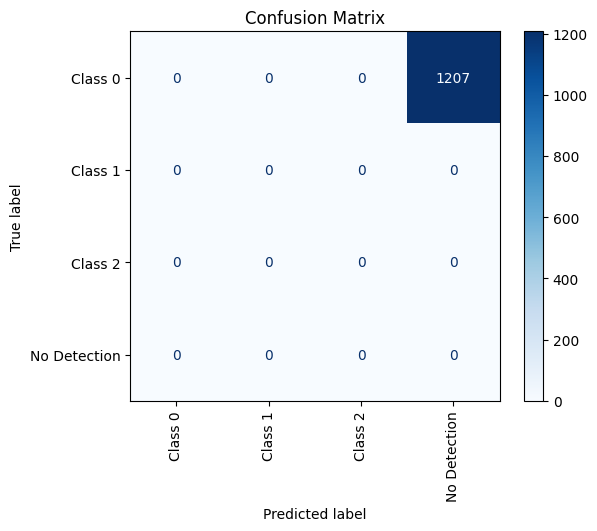

Total training time: 1589.14 seconds (26.49 minutes)


In [80]:
# Training and evaluation
import time

# Start time
start_time = time.time()

train(model, train_loader, optimizer, num_epochs=5)
evaluate_with_confusion_matrix(model, val_loader, num_classes=3)

end_time = time.time()

# Calculate and print training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")